Meaghan Woody

UP 213

Spring 2025

### 1. Access Census Data using the Census Bureau API

Request the following ACS variables to map SNAP Underenrollment:

https://api.census.gov/data/2015/acs/acs5/variables.html

Total Population:

    B22003_001E = (TOTAL POP) RECEIPT OF FOOD STAMPS/SNAP IN THE PAST 12 MONTHS BY POVERTY STATUS IN THE PAST 12 MONTHS FOR HOUSEHOLDS	

    B17017_002E = (TOTAL POP) POVERTY STATUS IN THE PAST 12 MONTHS BY HOUSEHOLD TYPE BY AGE OF HOUSEHOLDER	

Received food stamps:

    B22003_002E = Estimate!!Total!!Household received Food Stamps/SNAP in the past 12 months		
    
    B22003_003E = Estimate!!Total!!Household received Food Stamps/SNAP in the past 12 months!!Income in the past 12 months below poverty level	


Did not receive food stamps:

    B22003_005E = Estimate!!Total!!Household did not receive Food Stamps/SNAP in the past 12 months
    
    B22003_006E = Estimate!!Total!!Household did not receive Food Stamps/SNAP in the past 12 months!!Income in the past 12 months below poverty level

In [114]:
import json
import requests
import pandas as pd

r = requests.get('https://api.census.gov/data/2023/acs/acs5?get=B22003_001E&B17017_002E&B22003_002E&B22003_003E&B22003_005E&B22003_006E&for=tract:*&in=state:06%20county:037')
censusdata = r.json()
census_snap = pd.DataFrame(censusdata[1:], columns=censusdata[0])
census_snap.head()

B22003_001E B17017_002E B22003_002E B22003_003E B22003_005E B22003_006E  \
0        1558         247         283         103        1275         144   
1        1407          69         160          42        1247          27   
2        1357         215         324         149        1033          66   
3        1483         275         433         116        1050         159   
4         948         287         284         169         664         118   

  state county   tract  
0    06    037  101110  
1    06    037  101122  
2    06    037  101220  
3    06    037  101221  
4    06    037  101222

In [116]:
# Rename the variables 
census_snap = census_snap.rename(columns={
    'B22003_001E': 'total_hh',
    'B17017_002E': 'total_pov',
    'B22003_002E': 'snap_tot_hh',
    'B22003_003E': 'snap_pov_hh',
    'B22003_005E': 'nosnap_tot_hh',
    'B22003_006E': 'nosnap_pov_hh'
})

census_snap.head()

total_hh total_pov snap_tot_hh snap_pov_hh nosnap_tot_hh nosnap_pov_hh  \
0     1558       247         283         103          1275           144   
1     1407        69         160          42          1247            27   
2     1357       215         324         149          1033            66   
3     1483       275         433         116          1050           159   
4      948       287         284         169           664           118   

  state county   tract  
0    06    037  101110  
1    06    037  101122  
2    06    037  101220  
3    06    037  101221  
4    06    037  101222

### Calculate the following:

Observed SNAP Participation Rate: % of eligible households receiving SNAP benefits

    obs_snap = snap_tot_hh / total_pov * 100%

SNAP-Eligible But Not Enrolled (EBNE): percentage of households below the federal poverty level, who are not enrolled in the SNAP program. This is a conservative proxy for the percentage of eligible but not enrolled (EBNE) households by census tract, because, in CA, households can make less than or equal to 130% of the federal poverty level and still qualify for the SNAP program

    ebne_snap = nosnap_pov_hh / total_pov * 100%

In [119]:
census_snap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   total_hh       2498 non-null   object
 1   total_pov      2498 non-null   object
 2   snap_tot_hh    2498 non-null   object
 3   snap_pov_hh    2498 non-null   object
 4   nosnap_tot_hh  2498 non-null   object
 5   nosnap_pov_hh  2498 non-null   object
 6   state          2498 non-null   object
 7   county         2498 non-null   object
 8   tract          2498 non-null   object
dtypes: object(9)
memory usage: 175.8+ KB


In [121]:
# Convert variables to float in variable calculations

# Calculate observed SNAP participation: % of poverty households that received SNAP
census_snap['obs_snap'] = (census_snap.snap_pov_hh.astype(float) / census_snap.total_pov.astype(float)) * 100

# Calculate EBNE: % of poverty households not enrolled in SNAP
census_snap['ebne_snap'] = (census_snap.nosnap_pov_hh.astype(float) / census_snap.total_pov.astype(float)) * 100

# View new vars
census_snap.head()

total_hh total_pov snap_tot_hh snap_pov_hh nosnap_tot_hh nosnap_pov_hh  \
0     1558       247         283         103          1275           144   
1     1407        69         160          42          1247            27   
2     1357       215         324         149          1033            66   
3     1483       275         433         116          1050           159   
4      948       287         284         169           664           118   

  state county   tract   obs_snap  ebne_snap  
0    06    037  101110  41.700405  58.299595  
1    06    037  101122  60.869565  39.130435  
2    06    037  101220  69.302326  30.697674  
3    06    037  101221  42.181818  57.818182  
4    06    037  101222  58.885017  41.114983

In [123]:
# Check the distribution of these variables
census_snap[['obs_snap', 'ebne_snap']].boxplot()

<Axes: >

In [182]:
# Check for missing values
snap_tracts['obs_snap'].isna().sum() # 41
snap_tracts['ebne_snap'].isna().sum() #41 

41

## 2. Load in Shapefiles for Los Angeles County

Data obtained from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

In [127]:
import geopandas as gpd

# Load LA County tract shapefile
tracts = gpd.read_file('/Users/markwoody/Desktop/UP 213/UP213Final/final/tl_2020_06_tract_LACounty.zip')
print(tracts.columns)
tracts.head(5)

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')


STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  MTFCC  \
0      06      037  262601  06037262601  2626.01  Census Tract 2626.01  G5020   
1      06      037  300100  06037300100     3001     Census Tract 3001  G5020   
2      06      037  300501  06037300501  3005.01  Census Tract 3005.01  G5020   
3      06      037  310701  06037310701  3107.01  Census Tract 3107.01  G5020   
4      06      037  300200  06037300200     3002     Census Tract 3002  G5020   

  FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  Shape_Leng  \
0        S  3620351.0      0.0  +34.0738344  -118.5557893    0.108596   
1        S  4591342.0  18657.0  +34.2442558  -118.2325716    0.094693   
2        S  1260255.0      0.0  +34.2206887  -118.2400494    0.061435   
3        S   515339.0      0.0  +34.1853923  -118.3128440    0.036201   
4        S  1943986.0  10136.0  +34.2283768  -118.2386852    0.067506   

   Shape_Area                                           geometry  
0    0.000354  POLYGON ((-118.57556 34.08019, -118.57497 34.0...  
1    0.000451  POLYGON ((-118.2486 34.23881, -118.24858 34.23...  
2    0.000123  POLYGON ((-118.24875 34.22249, -118.24875 34.2...  
3    0.000050  POLYGON ((-118.31952 34.18495, -118.31915 34.1...  
4    0.000191  POLYGON ((-118.24864 34.23324, -118.24863 34.2...

In [14]:
# Create GEOID in both datasets
census_snap['GEOID'] = census_snap['state'] + census_snap['county'] + census_snap['tract']

# Set GEOID as index
tracts = tracts.set_index('GEOID')
census_snap = census_snap.set_index('GEOID')

# Join geometry from tracts into full census_snap
snap_tracts = census_snap.join(tracts[['geometry']], how='inner')
snap_tracts = gpd.GeoDataFrame(snap_tracts, geometry='geometry', crs='EPSG:4326')
snap_tracts.head(5)

total_hh total_pov snap_tot_hh snap_pov_hh nosnap_tot_hh  \
GEOID                                                                  
06037101110     1558       247         283         103          1275   
06037101122     1407        69         160          42          1247   
06037101220     1357       215         324         149          1033   
06037101221     1483       275         433         116          1050   
06037101222      948       287         284         169           664   

            nosnap_pov_hh state county   tract   obs_snap  ebne_snap  \
GEOID                                                                  
06037101110           144    06    037  101110  41.700405  58.299595   
06037101122            27    06    037  101122  60.869565  39.130435   
06037101220            66    06    037  101220  69.302326  30.697674   
06037101221           159    06    037  101221  42.181818  57.818182   
06037101222           118    06    037  101222  58.885017  41.114983   

                                                      geometry  
GEOID                                                           
06037101110  POLYGON ((-118.30229 34.2587, -118.30091 34.25...  
06037101122  POLYGON ((-118.30334 34.27371, -118.3033 34.27...  
06037101220  POLYGON ((-118.28593 34.25227, -118.28592 34.2...  
06037101221  POLYGON ((-118.29945 34.25598, -118.29792 34.2...  
06037101222  POLYGON ((-118.29434 34.25233, -118.29318 34.2...

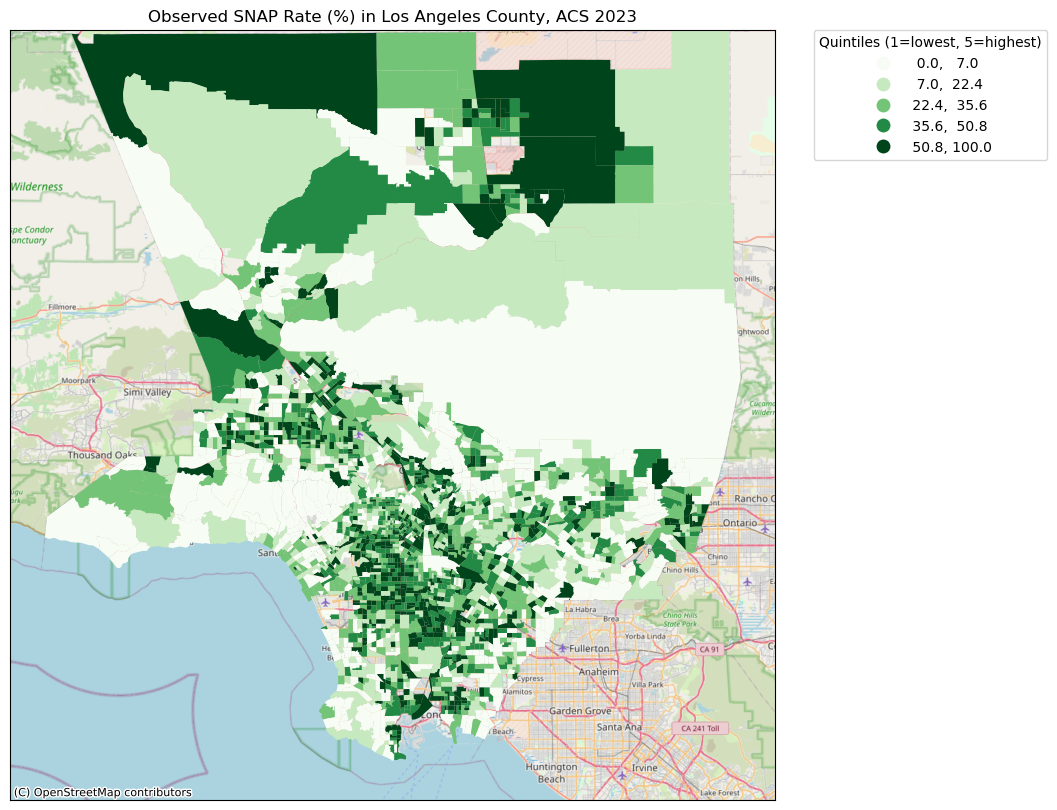

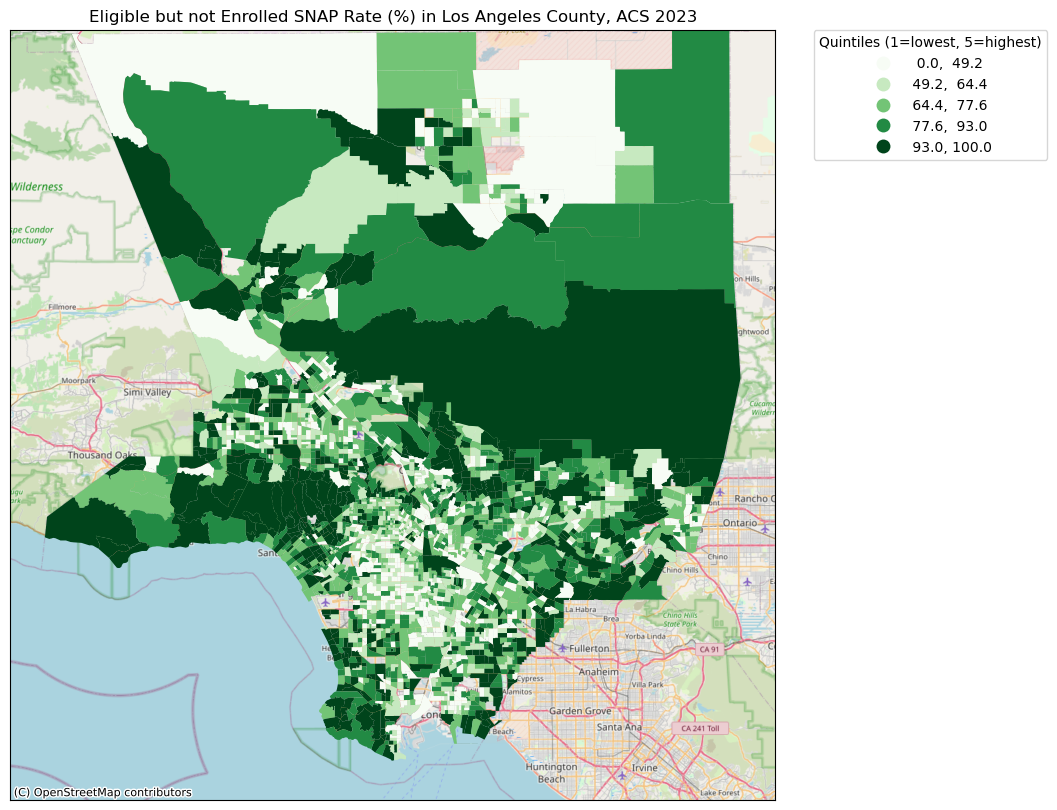

In [222]:
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx

# Choose colors here: https://matplotlib.org/stable/users/explain/colors/colormaps.html

for colname in ['obs_snap','ebne_snap']:    
    fig1, ax = plt.subplots(figsize=(16,10))

    snap_tracts.to_crs('EPSG:3857').plot(
        column=colname,
        scheme='quantiles',  
        k=5,                # Number of classes 
        cmap='Greens', 
        legend=True, 
        ax=ax, 
        alpha=1, # Higher for less transparancy 
        legend_kwds={
            'fmt': "{:.1f}",
            'title': "Quintiles (1=lowest, 5=highest)",
            'loc': 'upper left',  # Anchor point for legend
            'bbox_to_anchor': (1.05, 1),  # Positions legend outside (right side)
            'borderaxespad': 0  # Space between legend and axes
        }
    )
        
    # drop Catalina
    ax.set_ylim([3.98e6, 4.14e6])

    # add basemap
    ctx.add_basemap(ax=ax, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)
    
    # remove axis ticks and labels, so we set them to an empty list
    ax.set_xticks([])
    ax.set_yticks([])

    # map titles
    if colname == 'obs_snap':
        titletext = 'Observed SNAP Rate (%) in Los Angeles County, ACS 2023' 
    else:
        titletext = 'Eligible but not Enrolled SNAP Rate (%) in Los Angeles County, ACS 2023' 
        
    ax.set_title(titletext, fontsize=12)

    display(fig1)

### 3. Aggregate to Service Planning Areas

Downloaded Los Angeles County Service Planning Areas (SPAs) 2022 from https://egis-lacounty.hub.arcgis.com/datasets/lacounty::service-planning-areas-2022-view/about

In [200]:
spas = gpd.read_file('/Users/markwoody/Desktop/UP 213/UP213Final/final/Service_Planning_Areas_2022_view_8558881845522833049.zip')
spas = spas.to_crs(epsg=4326)
spas.head(5)

SPA         SPA_NAME ABBV  LABEL  SPA_NUM  \
0   1  Antelope Valley  ATV  SPA 1        1   
1   2     San Fernando  SFV  SPA 2        2   
2   3      San Gabriel  SGV  SPA 3        3   
3   4            Metro  MET  SPA 4        4   
4   5             West    W  SPA 5        5   

                                            geometry  
0  POLYGON ((-117.65523 34.39722, -117.65524 34.3...  
1  POLYGON ((-118.7659 34.75362, -118.77967 34.75...  
2  POLYGON ((-117.97228 34.43878, -117.9723 34.43...  
3  POLYGON ((-118.30434 34.15884, -118.30283 34.1...  
4  POLYGON ((-118.94469 34.045, -118.94463 34.045...

In [202]:
# Spatial join 
tracts_spa = gpd.sjoin(snap_tracts, spas, how='left', predicate='within')
tracts_spa.head(5)

total_hh total_pov snap_tot_hh snap_pov_hh nosnap_tot_hh  \
GEOID                                                                  
06037101110     1558       247         283         103          1275   
06037101122     1407        69         160          42          1247   
06037101220     1357       215         324         149          1033   
06037101221     1483       275         433         116          1050   
06037101222      948       287         284         169           664   

            nosnap_pov_hh state county   tract   obs_snap  ebne_snap  \
GEOID                                                                  
06037101110           144    06    037  101110  41.700405  58.299595   
06037101122            27    06    037  101122  60.869565  39.130435   
06037101220            66    06    037  101220  69.302326  30.697674   
06037101221           159    06    037  101221  42.181818  57.818182   
06037101222           118    06    037  101222  58.885017  41.114983   

                                                      geometry  \
GEOID                                                            
06037101110  POLYGON ((-118.30229 34.2587, -118.30091 34.25...   
06037101122  POLYGON ((-118.30334 34.27371, -118.3033 34.27...   
06037101220  POLYGON ((-118.28593 34.25227, -118.28592 34.2...   
06037101221  POLYGON ((-118.29945 34.25598, -118.29792 34.2...   
06037101222  POLYGON ((-118.29434 34.25233, -118.29318 34.2...   

            obs_snap_quintile ebne_snap_quintile  index_right SPA  \
GEOID                                                               
06037101110                 4                  2          1.0   2   
06037101122                 5                  1          1.0   2   
06037101220                 5                  1          1.0   2   
06037101221                 4                  2          1.0   2   
06037101222                 5                  1          1.0   2   

                 SPA_NAME ABBV  LABEL  SPA_NUM  
GEOID                                           
06037101110  San Fernando  SFV  SPA 2      2.0  
06037101122  San Fernando  SFV  SPA 2      2.0  
06037101220  San Fernando  SFV  SPA 2      2.0  
06037101221  San Fernando  SFV  SPA 2      2.0  
06037101222  San Fernando  SFV  SPA 2      2.0

In [204]:
# Aggregate up to SPAs
cols = ['obs_snap', 'ebne_snap']
spa_aggregated = tracts_spa.groupby('SPA')[cols].mean().reset_index()
spa_aggregated.head(5)

SPA   obs_snap  ebne_snap
0   1  38.400413  61.599587
1   2  30.307114  69.692886
2   3  25.257261  74.742739
3   4  34.663241  65.336759
4   5  16.968073  83.031927

In [214]:
# Merge with SPA geometries
snap_spa = spas.merge(spa_aggregated, on='SPA')
snap_spa.head(5)

SPA         SPA_NAME ABBV  LABEL  SPA_NUM  \
0   1  Antelope Valley  ATV  SPA 1        1   
1   2     San Fernando  SFV  SPA 2        2   
2   3      San Gabriel  SGV  SPA 3        3   
3   4            Metro  MET  SPA 4        4   
4   5             West    W  SPA 5        5   

                                            geometry   obs_snap  ebne_snap  
0  POLYGON ((-117.65523 34.39722, -117.65524 34.3...  38.400413  61.599587  
1  POLYGON ((-118.7659 34.75362, -118.77967 34.75...  30.307114  69.692886  
2  POLYGON ((-117.97228 34.43878, -117.9723 34.43...  25.257261  74.742739  
3  POLYGON ((-118.30434 34.15884, -118.30283 34.1...  34.663241  65.336759  
4  POLYGON ((-118.94469 34.045, -118.94463 34.045...  16.968073  83.031927

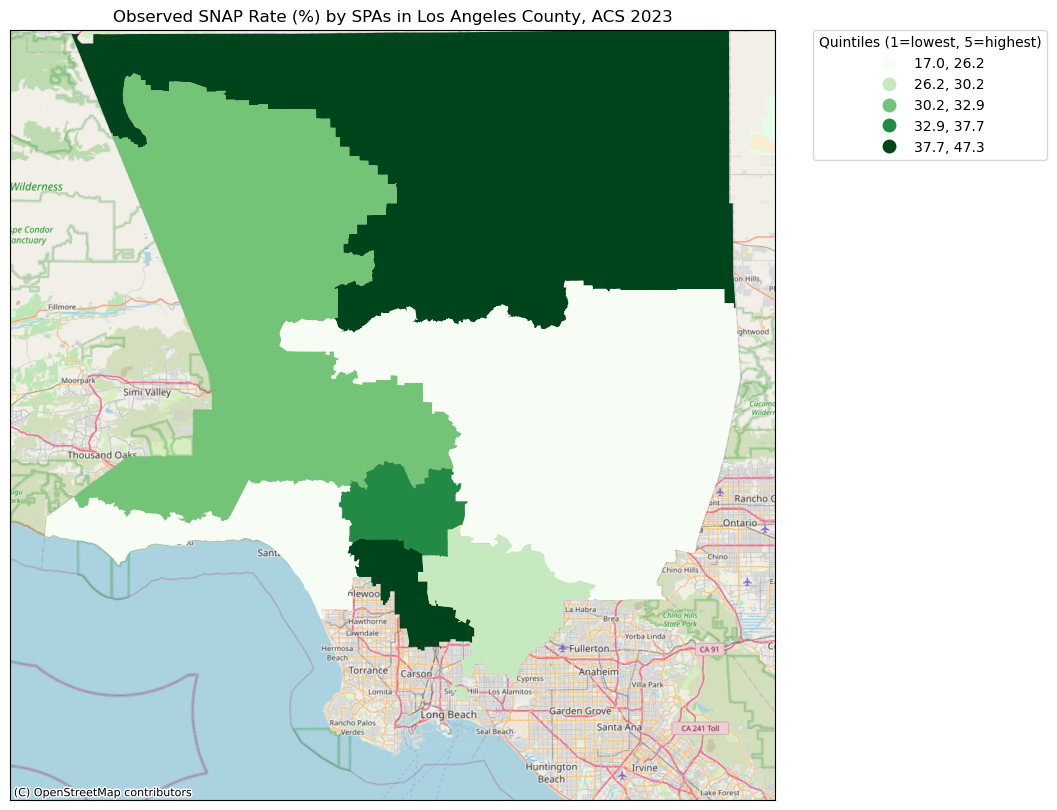

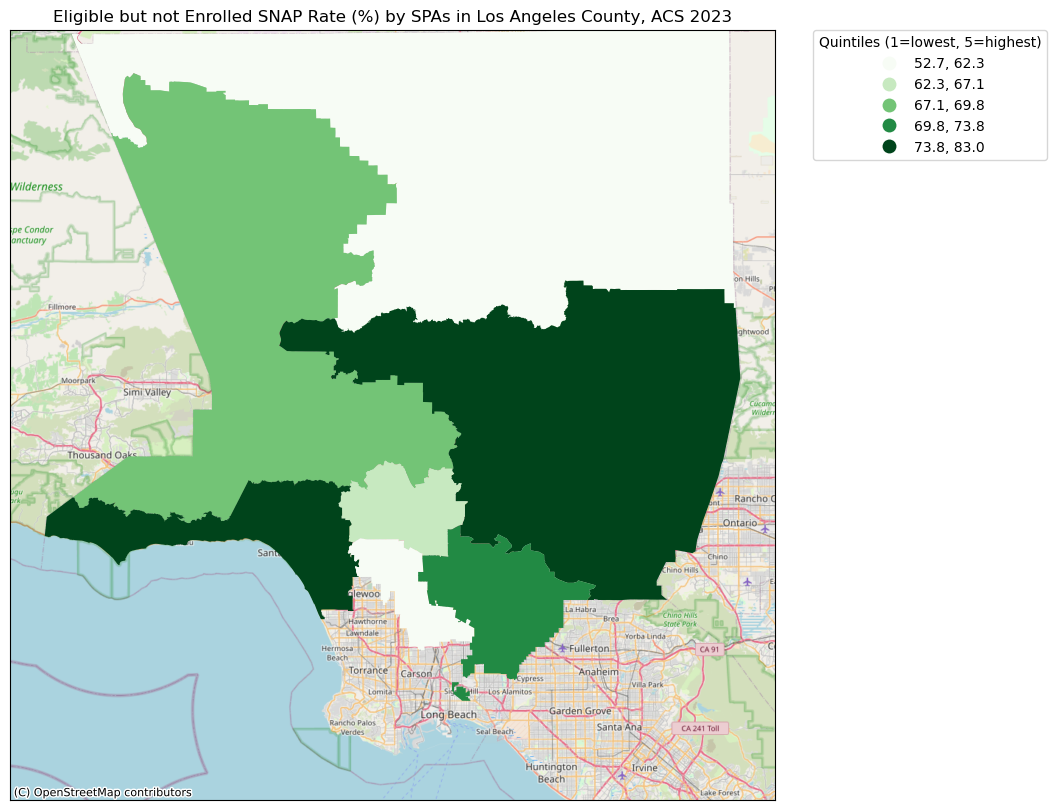

In [226]:
for colname in ['obs_snap','ebne_snap']:    
    fig2, ax = plt.subplots(figsize=(16,10))

    snap_spa.to_crs('EPSG:3857').plot(
        column=colname,
        scheme='quantiles',  
        k=5,                # Number of classes 
        cmap='Greens', 
        legend=True, 
        ax=ax, 
        alpha=1, # Higher for less transparancy 
        legend_kwds={
            'fmt': "{:.1f}",
            'title': "Quintiles (1=lowest, 5=highest)",
            'loc': 'upper left',  # Anchor point for legend
            'bbox_to_anchor': (1.05, 1),  # Positions legend outside (right side)
            'borderaxespad': 0  # Space between legend and axes
        }
    )
        
    # drop Catalina
    ax.set_ylim([3.98e6, 4.14e6])

    # add basemap
    ctx.add_basemap(ax=ax, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)
    
    # remove axis ticks and labels, so we set them to an empty list
    ax.set_xticks([])
    ax.set_yticks([])

    # map titles
    if colname == 'obs_snap':
        titletext = 'Observed SNAP Rate (%) by SPAs in Los Angeles County, ACS 2023' 
    else:
        titletext = 'Eligible but not Enrolled SNAP Rate (%) by SPAs in Los Angeles County, ACS 2023' 
        
    ax.set_title(titletext, fontsize=12)

    display(fig2)

### Summary of SPA Attributes

In [237]:
# Create summary table
summary_table = snap_spa[['SPA_NAME', 'obs_snap', 'ebne_snap']].groupby('SPA_NAME').mean()

summary_table = summary_table.rename(columns={
    'obs_snap': 'Avg SNAP Rate (%)',
    'ebne_snap': 'Avg EBNE Rate (%)'
})

# Sort by SNAP rate (highest to lowest)
summary_table = summary_table.sort_values('Avg SNAP Rate (%)', ascending=False)

# Format with 1 decimal place
summary_table = summary_table.round(1)

from IPython.display import display, HTML
display(HTML(summary_table.to_html()))

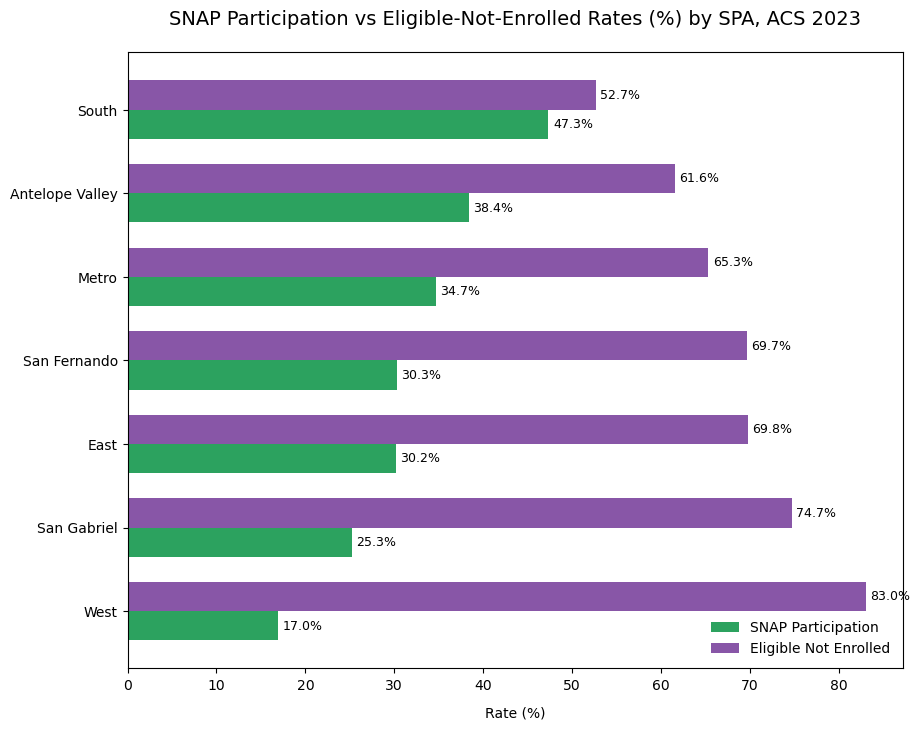

In [245]:
# Create a bar chart 
spa_names = summary_table.index 

fig3, ax = plt.subplots(figsize=(10, 8))
width = 0.35  # Width of each bar
y = np.arange(len(spa_names))  # y positions

bars1 = ax.barh(y - width/2, summary_table['obs_snap'], width, 
                label='SNAP Participation', color='#2ca25f')
bars2 = ax.barh(y + width/2, summary_table['ebne_snap'], width, 
                label='Eligible Not Enrolled', color='#8856a7')

ax.set_title('SNAP Participation vs Eligible-Not-Enrolled Rates (%) by SPA, ACS 2023', pad=20, fontsize=14)
ax.set_xlabel('Rate (%)', labelpad=10)
ax.set_yticks(y)
ax.set_yticklabels(spa_names)
ax.legend(loc='lower right', frameon=False)

for bar in bars1 + bars2:
    width = bar.get_width()
    ax.text(width + 0.5,  
            bar.get_y() + bar.get_height()/2,
            f'{width:.1f}%',
            va='center',
            fontsize=9)

display(fig3)

### 4. Maps for Food Insecurity 

Downloaded data from Los Angeles City Geohub:

SPA and food insecurity - https://geohub.lacity.org/datasets/9ecfeddddb9e4630aa10c92b0daeea6c_0/explore?location=33.771520%2C-118.353165%2C8.16

    Food insecurity rates by SPAs

Population in Households with Food Insecurity - https://geohub.lacity.org/datasets/9b5c7a6b308f4091813d0e6e64e852c7_0/explore?location=33.871267%2C-118.342846%2C8.43

    Percentage of Population Living in Households with Food Insecurity. Data provided by Los Angeles County Department of Public Health (DPH) for the Community Health Profiles (CHP) Data Initiative.

USDA Food Deserts - https://geohub.lacity.org/datasets/7fb7f906515a490486a173bdba086d1b_0/explore?location=34.019145%2C-118.411766%2C9.94 
    
    USDA data on food deserts, SNAP recipients by census tract.

In [286]:
spa_fi = gpd.read_file('/Users/markwoody/Desktop/UP 213/UP213Final/final/SPA_and_food_insecurity.zip')
print(spa_fi.columns)
spa_fi.head(5)

Index(['OBJECTID_1', 'OBJECTID', 'SPA_NAME', 'LABEL', 'ABBV', 'SPA_2012',
       'Join_Count', 'SPA_Number', 'Median_Inc', 'Index_', 'SPA', 'Food_Secur',
       'Food_Insec', 'geometry'],
      dtype='object')


OBJECTID_1  OBJECTID         SPA_NAME LABEL   ABBV  SPA_2012  Join_Count  \
0           1         6            South     S  SPA 6         6           1   
1           2         4            Metro   MET  SPA 4         4           1   
2           3         1  Antelope Valley   ATV  SPA 1         1           1   
3           4         7             East     E  SPA 7         7           1   
4           5         8        South Bay   SBA  SPA 8         8           1   

   SPA_Number  Median_Inc  Index_    SPA Food_Secur Food_Insec  \
0           6       36400       6  SPA 6        11%        16%   
1           4       47173       4  SPA 4        13%        17%   
2           1       57423       1  SPA 1         4%         4%   
3           7       57726       7  SPA 7        20%        22%   
4           8       66794       8  SPA 8        11%         9%   

                                            geometry  
0  POLYGON ((-13174153 4034170, -13174075 4034151...  
1  POLYGON ((-13169580 4050151, -13168967 4049995...  
2  POLYGON ((-13106257 4139884, -13098683 4139787...  
3  MULTIPOLYGON (((-13154550 4036241, -13154545 4...  
4  MULTIPOLYGON (((-13176472 4026338, -13173014 4...

In [292]:
# Remove the % format on Food_Insec column and convert to float
spa_fi['FI'] = spa_fi['Food_Insec'].str.replace('%', '').astype(float)
print(spa_fi['FI'])

0    16.0
1    17.0
2     4.0
3    22.0
4     9.0
5    18.0
6     9.0
7     5.0
Name: FI, dtype: float64


In [255]:
city_fi = gpd.read_file('/Users/markwoody/Desktop/UP 213/UP213Final/final/Population_with_Food_Insecurity_3358006855397152269.zip')
print(tracts_fi.columns)
city_fi.head(5)

Index(['Geo_ID', 'Geo_Type', 'Geo_Name', 'POP_FI', 'POP_FI_LCL', 'POP_FI_UCL',
       'POP_FI_RSE', 'POP_FI_EST', 'geometry'],
      dtype='object')


Geo_ID           Geo_Type              Geo_Name  POP_FI  \
0  csa_city_agoura_hills  Incorporated City  City of Agoura Hills     0.0   
1      csa_city_alhambra  Incorporated City      City of Alhambra    21.1   
2       csa_city_arcadia  Incorporated City       City of Arcadia    13.0   
3       csa_city_artesia  Incorporated City       City of Artesia     0.0   
4         csa_city_azusa  Incorporated City         City of Azusa    25.3   

   POP_FI_LCL  POP_FI_UCL  POP_FI_RSE           POP_FI_EST  \
0         0.0         0.0         0.0                 None   
1        19.0        23.2         5.1  small area estimate   
2        11.3        14.7         6.6  small area estimate   
3         0.0         0.0         0.0                 None   
4        23.1        27.6         4.5  small area estimate   

                                            geometry  
0  POLYGON ((6341261 1884292.5, 6341258 1884280, ...  
1  POLYGON ((6525011 1860749.875, 6525931.5 18612...  
2  POLYGON ((6559632.5 1869453.625, 6559431 18690...  
3  POLYGON ((6535014.5 1778847.125, 6535273.5 177...  
4  POLYGON ((6594928.5 1882488.75, 6594928.5 1882...

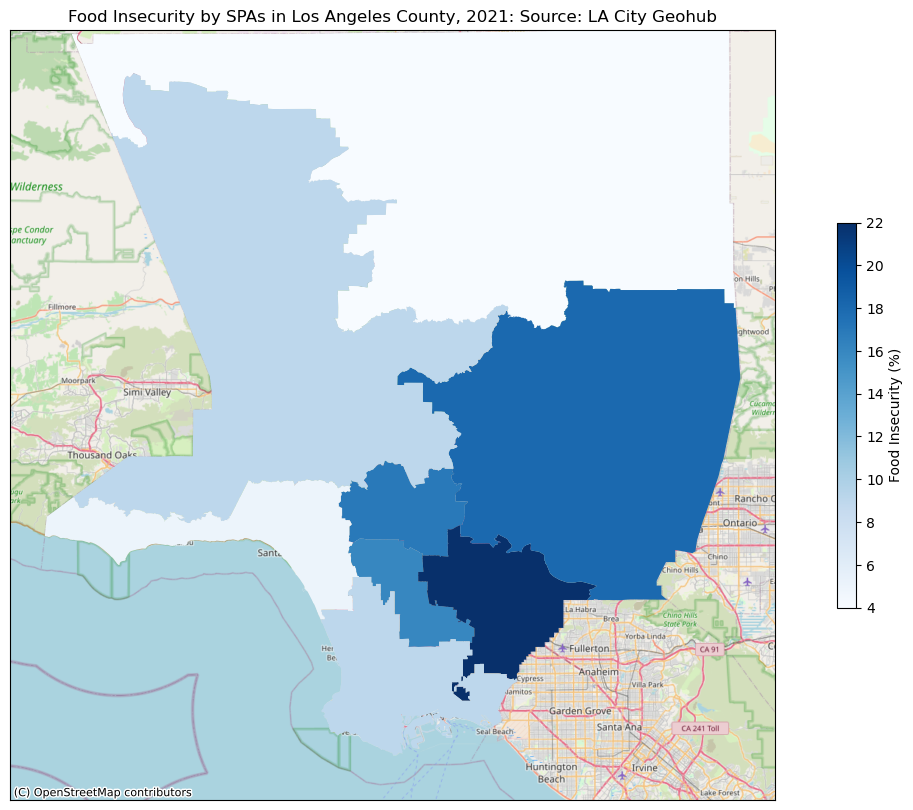

In [314]:
fig4, ax = plt.subplots(figsize=(16,10))

spa_fi.to_crs('EPSG:3857').plot(
    column='FI',
        ax=ax,
        markersize=20,  # Consistent size
        cmap='Blues',
        legend=True,
        legend_kwds={'label': "Food Insecurity (%)",
        'shrink': 0.5,  # make the color bar shorter
        'aspect': 20} # controls width — higher = skinnier                         
                     )

# drop Catalina
ax.set_ylim([3.98e6, 4.14e6])

# add a basemap
ctx.add_basemap(ax=ax, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)

# drop the tick labels
ax.set_xticks([])
ax.set_yticks([])

# add a title
ax.set_title('Food Insecurity by SPAs in Los Angeles County, 2021: Source: LA City Geohub')

display(fig4)

In [316]:
# Create summary table for FI
fi_summary = spa_fi[['SPA_NAME', 'FI']].groupby('SPA_NAME').mean()

# Rename and format
fi_summary = fi_summary.rename(columns={'FI': 'Food Insecurity Rate (%)'})
fi_summary = fi_summary.round(1)

# Sort highest to lowest
fi_summary = fi_summary.sort_values('Food Insecurity Rate (%)', ascending=False)

# Display as HTML table
from IPython.display import display, HTML
display(HTML(fi_summary.to_html()))

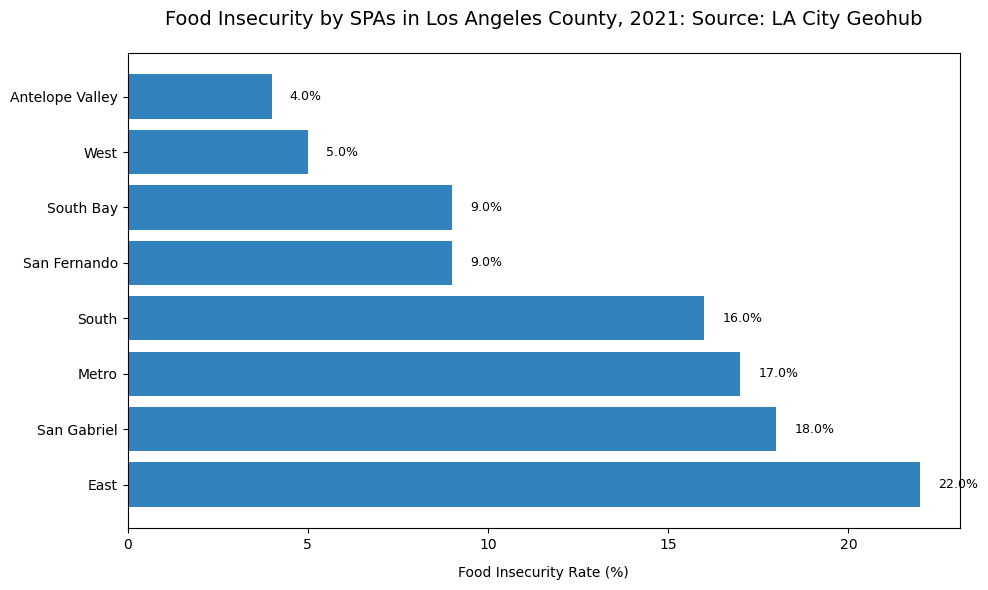

In [322]:
spa_names = fi_summary.index
rates = fi_summary['Food Insecurity Rate (%)']

fig5, ax = plt.subplots(figsize=(10, 6))
y = np.arange(len(spa_names))

bars = ax.barh(y, rates, color='#3182bd') 

# Labels and titles
ax.set_title('Food Insecurity by SPAs in Los Angeles County, 2021: Source: LA City Geohub', pad=20, fontsize=14)
ax.set_xlabel('Food Insecurity Rate (%)', labelpad=10)
ax.set_yticks(y)
ax.set_yticklabels(spa_names)

# Add data labels to bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', fontsize=9)

plt.tight_layout()
display(fig5)

### Map FI for LA Cities

"Data for cities, communities, and City of Los Angeles Council Districts were generated using a small area estimation method which combined the survey data with population benchmark data (2022 population estimates for Los Angeles County) and neighborhood characteristics data (e.g., U.S. Census Bureau, 2017-2021 American Community Survey 5-Year Estimates). Households experiencing food insecurity are defined as those with low food security or very low food security in the last 12 months. Food insecurity is assessed by a scaled variable created from a series of five questions."

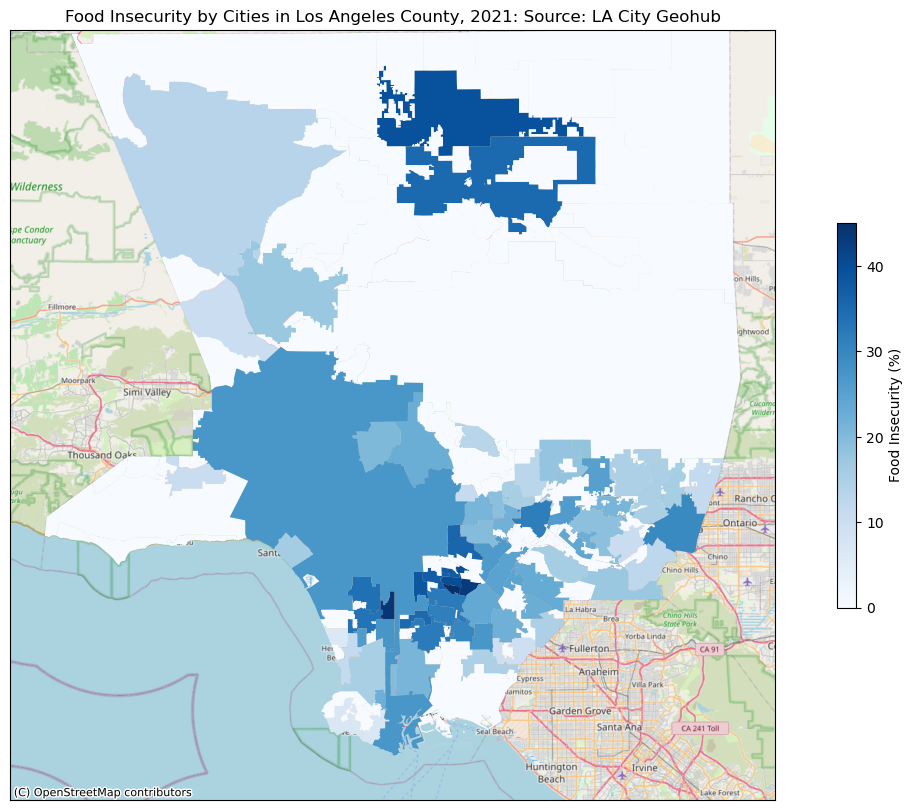

In [325]:
fig6, ax = plt.subplots(figsize=(16,10))

city_fi.to_crs('EPSG:3857').plot(
    column='POP_FI',
        ax=ax,
        markersize=20,  # Consistent size
        cmap='Blues',
        legend=True,
        legend_kwds={'label': "Food Insecurity (%)",
        'shrink': 0.5,  # make the color bar shorter
        'aspect': 20} # controls width — higher = skinnier                         
                     )

# drop Catalina
ax.set_ylim([3.98e6, 4.14e6])

# add a basemap
ctx.add_basemap(ax=ax, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)

# drop the tick labels
ax.set_xticks([])
ax.set_yticks([])

# add a title
ax.set_title('Food Insecurity by Cities in Los Angeles County, 2021: Source: LA City Geohub')

display(fig6)